#### <span style="color:#dcdc9f;font-weight: 600">Imports iniciais</span>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import locale

#### <span style="color:#dcdc9f;font-weight: 600">Configurando</span>

In [ ]:
sns.set_style("whitegrid")
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("deep")
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

THREADS_VALUES = [2, 4, 8, 10, 24]

df = pd.read_csv('../Resultados/metricas_resultados.csv', delimiter=';')

#### <span style="color:#dcdc9f;font-weight: 600">Dados não tratados</span>

In [ ]:
df.head(1000)

## <span style="color:#dcdc9f;font-weight: 600">Tabelas</span>

In [ ]:
tabela = df.groupby(["Algoritmo", "Tipo"])["Duração (ms)"].agg(
    media="mean",
    min="min",
    max="max",
).round(3)

tabela_formatada = tabela.applymap(lambda x: locale.format_string("%.3f", x, grouping=True))
tabela_formatada

In [ ]:
tabela = df.groupby(["Algoritmo", "Tipo"])["Duração (ms)"].agg(
    media="mean",
    min="min",
    max="max",
).round(3)

tabela_formatada = tabela.applymap(lambda x: locale.format_string("%.3f", x, grouping=True))
tabela_formatada

In [ ]:
df_filtrado = df[df["Tamanho do array"] > 10000]
tabela = df_filtrado.groupby(["Algoritmo", "Tipo", "Tamanho do array"])["Duração (ms)"].agg(
    media="mean",
    min="min",
    max="max",
).round(3)

tabela

In [ ]:
df_filtrado_novo = df[df["Tamanho do array"] == 10_000_000]
tabela = df_filtrado_novo.groupby(["Algoritmo", "Tipo", "Quant. de threads"])["Duração (ms)"].agg(
    media="mean",
    min="min",
    max="max",
).round(3)

tabela

## <span style="color:#dcdc9f;font-weight: 600">Gráficos</span>

In [ ]:
media_tempo = (
    df.groupby(["Algoritmo", "Tipo"])["Duração (ms)"]
      .mean()
      .reset_index()
)

plt.figure(figsize=(10, 6))
grafico = sns.barplot(data=media_tempo, x="Algoritmo", y="Duração (ms)", hue="Tipo")
plt.title("Comparação de Tempo: Serial vs Paralelo")
plt.ylabel("Duração média (ms)")
plt.xlabel("Algoritmo")
plt.xticks(rotation=45)

for barra in grafico.patches:
    altura = barra.get_height()
    grafico.annotate(f'{altura:.1f}', 
                     xy=(barra.get_x() + barra.get_width() / 2, altura),
                     xytext=(0, 5), 
                     textcoords="offset points",
                     ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
tabela = df.groupby(["Tipo", "Algoritmo"])["Duração (ms)"].mean().unstack()
algoritmo_serial = "SERIAL"
speedup = tabela.apply(lambda linha: linha[algoritmo_serial] / linha)
speedup_formatado = speedup.round(3).applymap(lambda x: locale.format_string("%.3f", x, grouping=True))
speedup_formatado

speedup_plot = tabela.apply(lambda linha: linha[algoritmo_serial] / linha)
fig, ax = plt.subplots(figsize=(10, 6))
bars = speedup_plot.plot(kind="bar", ax=ax)

ax.set_title("Speedup Paralelismo e Serial", fontsize=14)
ax.set_ylabel("Speedup", fontsize=12)
ax.set_xlabel("Tipo de tarefa", fontsize=12)
ax.legend(title="Algoritmo")
ax.grid(True, linestyle="--", alpha=0.5)

for container in bars.containers:
    for bar in container:
        height = bar.get_height()
        if not pd.isna(height):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{height:.2f}",
                ha="center",
                va="bottom",
                fontsize=9,
                rotation=0
            )

plt.tight_layout()
plt.show()

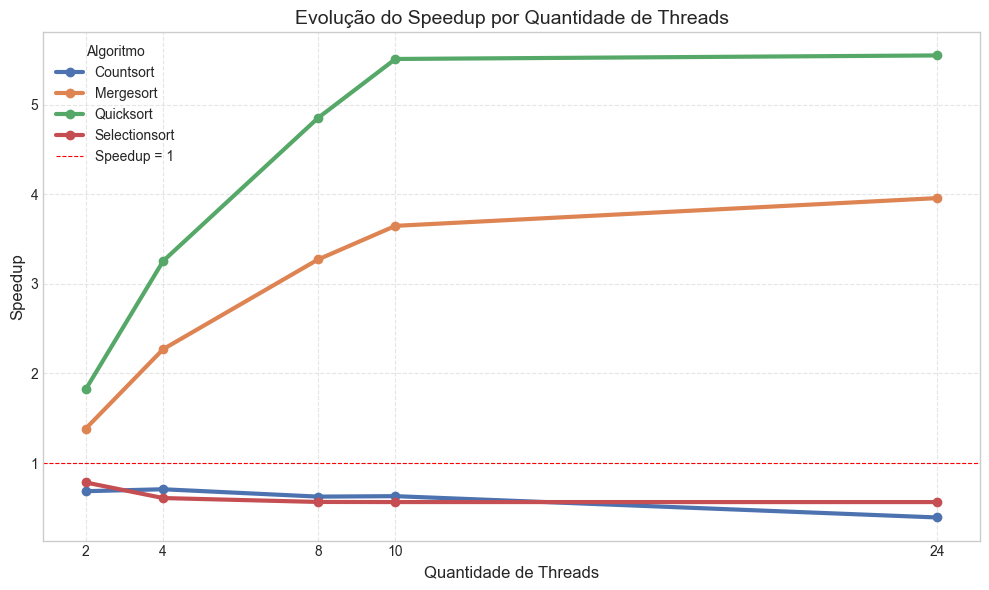

In [ ]:
tabela_completa = df.groupby(["Tipo", "Algoritmo", "Quant. de threads"])["Duração (ms)"].mean().reset_index()

tipo_serial = "SERIAL"

serial_times = tabela_completa[tabela_completa["Tipo"] == tipo_serial][["Algoritmo", "Duração (ms)"]]
serial_times = serial_times.rename(columns={"Duração (ms)": "Duração Serial"})

tabela_paralela = tabela_completa[tabela_completa["Tipo"] != tipo_serial].copy()

tabela_plot = tabela_paralela.merge(serial_times, on=["Algoritmo"])

tabela_plot["Speedup"] = tabela_plot["Duração Serial"] / tabela_plot["Duração (ms)"]

tabela_plot["Quant. de threads"] = pd.to_numeric(tabela_plot["Quant. de threads"], errors='coerce')
tabela_plot = tabela_plot.dropna(subset=["Quant. de threads"])
tabela_plot = tabela_plot.sort_values(by=["Tipo", "Algoritmo", "Quant. de threads"])


fig, ax = plt.subplots(figsize=(10, 6))

for algoritmo in tabela_plot["Algoritmo"].unique():
    dados = tabela_plot[tabela_plot["Algoritmo"] == algoritmo]
    
    ax.plot(dados["Quant. de threads"], dados["Speedup"], marker='o', label=algoritmo, linewidth=3)

ax.set_title("Evolução do Speedup por Quantidade de Threads", fontsize=14)
ax.set_xlabel("Quantidade de Threads", fontsize=12)
ax.set_ylabel("Speedup", fontsize=12)

ax.axhline(1, color='red', linestyle='--', linewidth=0.8, label="Speedup = 1")
ax.set_xticks(tabela_plot["Quant. de threads"].unique()) 

ax.grid(True, linestyle="--", alpha=0.5)
ax.legend(title="Algoritmo", loc="best")
plt.tight_layout()
plt.show()

In [ ]:
estat = (
    df[
        (df["Tipo"].str.contains("Paralelo", case=False, na=False)) &
        (df["Duração (ms)"] <= 2000)
    ]
    .groupby(["Algoritmo", "Tipo", "Quant. de threads", "Tamanho do array"])["Duração (ms)"]
    .agg(["count", "mean", "std", "min", "max"])
    .round(3)
)

estat_reset = estat.reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=estat_reset,
    x="Quant. de threads",
    y="mean",
    hue="Algoritmo",
    style="Tamanho do array",
    markers=True,
    linewidth=4,
    markersize=10,
    dashes=False
)

plt.xticks(THREADS_VALUES)

x_max = estat_reset["Quant. de threads"].max()
for (algoritmo, tamanho), grupo in estat_reset.groupby(["Algoritmo", "Tamanho do array"]):
    ultimo = grupo.sort_values("Quant. de threads").iloc[-1]
    plt.text(
        x=x_max + 0.5,
        y=ultimo["mean"],
        s=f"{int(ultimo['Tamanho do array']):,}".replace(",", "."),
        fontsize=8,
        alpha=0.7
    )

plt.xlim(1, x_max + 3)

plt.title("Média de duração (até 2000 ms) por quantidade de threads e tamanho do array")
plt.xlabel("Quantidade de threads")
plt.ylabel("Duração média (ms)")
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
estat = (
    df[
        (df["Duração (ms)"] < 2001) &
        (df["Tamanho do array"] == 10000000)
    ]
    .groupby(["Algoritmo", "Tipo", "Quant. de threads", "Tamanho do array"])["Duração (ms)"]
    .agg(["count", "mean", "std", "min", "max"])
    .round(3)
)

estat_reset = estat.reset_index()
estat_reset["Quant. de threads"] = estat_reset["Quant. de threads"].fillna(1)
estat_reset["Quant. de threads"] = estat_reset["Quant. de threads"].astype(int)

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=estat_reset,
    x="Quant. de threads",
    y="mean",
    hue="Algoritmo",
    style="Tipo",
    markers=True,
    linewidth=4,
    markersize=10,
    dashes=False
)

plt.xticks(sorted(set(THREADS_VALUES + [1])))
plt.title("Média de duração (até 2000 ms) por quantidade de threads e tamanho do array\nTamanho do Array = 10.000.000")
plt.xlabel("Quantidade de Threads")
plt.ylabel("Duração média (ms)")
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [ ]:
def formatar_valor(valor):
    if pd.isna(valor):
        return ""
    return f"{valor:,.1f}".replace(",", "X").replace(".", ",").replace("X", ".")

df_filtrado = df[df["Duração (ms)"] <= 2000000].copy()

df_filtrado["Tamanho formatado"] = df_filtrado["Tamanho do array"].apply(lambda x: f"{x:,}".replace(",", "."))

df_filtrado["Algoritmo - Tamanho"] = df_filtrado.apply(
    lambda row: (row["Algoritmo"], row["Tamanho do array"], f"{row['Algoritmo']}\n{row['Tamanho formatado']}"),
    axis=1
)
df_filtrado["Rótulo ordenado"] = df_filtrado["Algoritmo - Tamanho"].apply(lambda x: x[2])

pivot = (
    df_filtrado
    .groupby(["Rótulo ordenado", "Quant. de threads"])["Duração (ms)"]
    .mean()
    .unstack()
)

ordenacao = df_filtrado.drop_duplicates("Rótulo ordenado").sort_values(["Algoritmo", "Tamanho do array"])["Rótulo ordenado"]
pivot = pivot.loc[ordenacao]

pivot_formatado = pivot.applymap(formatar_valor)

plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot,
    annot=pivot_formatado,
    fmt="",
    cmap="YlGnBu",
    linewidths=0.5,
    linecolor="gray"
)

plt.title("Duração média por Algoritmo e Tamanho do Array")
plt.xlabel("Quantidade de Threads")
plt.ylabel("Algoritmo\nTamanho do Array")
plt.tight_layout()
plt.show()


In [ ]:
pivot = (
    df[df["Duração (ms)"] <= 2000]
    .groupby(["Quant. de threads", "Algoritmo"])["Duração (ms)"]
    .mean()
    .unstack()
)

pivot.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Tempo total por Threads (empilhado por Algoritmo)")
plt.ylabel("Duração média (ms)")
plt.xlabel("Quantidade de Threads")
plt.tight_layout()
plt.show()
